<a href="https://colab.research.google.com/github/ikhlas15/ATHENS-AI-Medical-Imaging/blob/main/H06_training_loop_and_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 06: The Complete Training Loop and Evaluation Metrics in PyTorch**

### **Course**: Artificial Intelligence in Medical Imaging: From Fundamentals to Applications

***

## **1. Introduction**

This is it! In this notebook, we will bring together everything you've learned so far—Tensors, Autograd, Datasets, and `nn.Module`—to create a complete training pipeline for a deep learning model. This is the heart of any deep learning project.

By the end of this session, you will have trained your first Convolutional Neural Network (CNN) to detect pneumonia from chest X-rays.

#### **What you will learn today:**
*   How to define a **loss function** and an **optimizer**, the two final pieces of the training puzzle.
*   To write a reusable **training loop** that performs the full cycle: forward pass, loss calculation, backward pass (gradient computation), and parameter update.
*   To create a **validation loop** to monitor your model's performance on unseen data and detect overfitting.
*   How to calculate and interpret key **classification metrics** for medical tasks, such as accuracy, precision, recall, and F1-score.
*   How to plot training progress to diagnose your model's learning behavior.

***

## **2. Setup: Installing and Importing Libraries**

Let's start by getting our environment ready. We will use the `medmnist` dataset, `torch` for our framework, and `scikit-learn` to help with metrics.


In [ ]:
# TODO Install required packages torch torchvision medmnist scikit-learn


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from medmnist import PneumoniaMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns  # create beautiful and informative plots

# Random seeds
# TODO: use the standard seed (hint: 42)
torch.manual_seed(____)

# TODO: same seed
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(____)

# Set device
# TODO: Fill: "cuda" and "cpu"
device = torch.device("____" if torch.cuda.is_available() else "____")


print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.0 MB/s eta 0:00:00
Using device: cuda


***

## **3. Preparing the Data**

We will use the same data loading pipeline as in the last notebook, preparing the PneumoniaMNIST dataset with transforms and `DataLoaders`. For this notebook, we'll use slightly larger subsets to better simulate a real training process.


In [ ]:

from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from medmnist import PneumoniaMNIST

# TODO: Normalize the images
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.____(mean=[0.5], std=[0.5])
])
# TODO: "train"
train_dataset_full = PneumoniaMNIST(split=____, transform=data_transforms, download=True)
# TODO: "val"
val_dataset_full   = PneumoniaMNIST(split=____, transform=data_transforms, download=True)
# TODO: "test"
test_dataset_full  = PneumoniaMNIST(split=____, transform=data_transforms, download=True)
# TODO: keep 4000 samples
train_subset = Subset(train_dataset_full, range(____))
# TODO  # Use the full validation set
val_subset   = Subset(val_dataset_full, range(len(____)))
# Use the full test set
test_subset  = Subset(test_dataset_full, range(len(____)))

# TODO: batch_size=64, shuffle=True
train_loader = DataLoader(dataset=train_subset, batch_size=____, shuffle=____)

# TODO: batch_size=64, shuffle=False
val_loader   = DataLoader(dataset=val_subset, batch_size=____, shuffle=____)

# TODO: batch_size=64, shuffle=False
test_loader  = DataLoader(dataset=test_subset, batch_size=____, shuffle=____)

# TODO: train_subset
print(f"Training on {len(____)} images.")
# TODO: val_subset
print(f"Validating on {len(____)} images.")
# TODO: test_subset
print(f"Testing on {len(____)} images.")

100%|██████████| 4.17M/4.17M [00:06<00:00, 620kB/s]


Training on 4000 images.
Validating on 524 images.
Test on 624 images.


***

## **4. Defining the Model, Loss Function, and Optimizer**

Let's bring back our `SimpleCNN` from the last notebook.

### **Model**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            # TODO: fill input/output channels → hint: grayscale image has 1 channel
            nn.Conv2d(____, ____, kernel_size=3, padding=1),
            # TODO: ReLU
            nn.____(),
            # TODO: kernel size for pooling (hint: 2)
            nn.MaxPool2d(____)
        )
        self.conv_block2 = nn.Sequential(
            # TODO: channels from previous block (16 → 32)
            nn.Conv2d(____, ____, kernel_size=3, padding=1),
            # TODO: ReLU
            nn.____(),
            # TODO: 2
            nn.MaxPool2d(____)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # TODO: input features = 32 * 7 * 7, output = 128
            nn.Linear(____, ____),
            # TODO: ReLU
            nn.____(),
            # TODO: 128 → 2 classes
            nn.Linear(____, ____ )

        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

# TODO: SimpleCNN()
model = ____().to(device)
print(model)


SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


### **Loss Function and Optimizer**

These are the final two components we need:
1.  **Loss Function (Criterion):** Measures how far the model's predictions are from the true labels. For a multi-class classification problem like ours, `nn.CrossEntropyLoss` is the standard choice. It conveniently combines a `LogSoftmax` and `NLLLoss` in one step.
2.  **Optimizer:** Implements an algorithm to update the model's weights based on the gradients computed during the backward pass. The goal is to minimize the loss. **Adam** is a popular, robust, and generally good default choice.


In [ ]:
# Define the loss function CrossEntropyLoss
criterion = nn.___()

# Define the optimizer Adam
# We pass model.parameters() to tell the optimizer which tensors it should update.
optimizer = optim.____(____, lr=0.001)

***

## **5. Building the Training and Validation Loops**

We will create two functions: one for a single epoch of training and one for validation.

### **The Training Function**
This function will iterate through all batches in the `train_loader`, and for each batch, it will:
1.  Move the data to the `device`.
2.  Reset the gradients (`optimizer.zero_grad()`).
3.  Perform a **forward pass** to get model predictions.
4.  Calculate the **loss**.
5.  Perform a **backward pass** (`loss.backward()`) to compute gradients.
6.  Update the model's weights (`optimizer.step()`).
7.  Track the loss and metrics.

In [ ]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    # TODO: call the training mode method → hint: model.train()
    model.____()

    total_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in data_loader:
        # TODO: device
        images = images.to(____)
        # TODO: convert labels to long integers → .long()
        labels = labels.to(____).squeeze().____()

       # 1. Clear previous gradients
        # TODO: zero_grad()
        optimizer.____()

        # 2. Forward pass
        # TODO: images
        outputs = model(____)

        # 3. Calculate the loss
        # TODO: outputs, labels
        loss = criterion(____, ____)

        # 4. Backward pass (compute gradients)
        # TODO: backward()
        loss.____()

        # 5. Update weights
        # TODO: step()
        optimizer.____()

        # Accumulate metrics and loss
        total_loss += loss.item() * images.size(0)

        # TODO: 1 → dimension over classes
        predictions = torch.argmax(outputs, dim=____)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    # Compute final metrics
    epoch_loss = total_loss / len(data_loader.dataset)
    # TODO: all_labels, all_predictions
    accuracy = accuracy_score(____, ____)

    return epoch_loss, accuracy


### **The Validation Function**
This function is very similar but with two key differences:
1.  We set the model to evaluation mode (`model.eval()`). This disables layers like Dropout and BatchNorm that behave differently during training and inference.
2.  We wrap the loop in `with torch.no_grad():`, which tells PyTorch not to calculate gradients, saving memory and computation.


In [ ]:
def evaluate(model,data_loader,criterion,device):
  model.____

  total_loss = 0.0
    all_labels = []
    all_predictions = []
  # TODO: no_grad()
  with torch.____():
        for images, labels in data_loader:

            # Move batch to device
            # TODO: device
            images = images.to(____)
            # TODO: convert labels to long ints: .long()
            labels = labels.to(____).squeeze().____()


            # Forward pass only
            # TODO: images
            outputs = model(____)

            # Compute loss
            # TODO: outputs, labels
            loss = criterion(____, ____)

            total_loss += loss.item() * images.size(0)

            # Predictions
            # TODO: dim=1 → class dimension
            predictions = torch.argmax(outputs, dim=____)


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute metrics

    epoch_loss = total_loss / len(data_loader.dataset)
    # TODO: all_labels, all_predictions
    accuracy  = accuracy_score(____, ____)
    precision = precision_score(____, ____, zero_division=0)
    recall    = recall_score(____, ____, zero_division=0)
    f1        = f1_score(____, ____, zero_division=0)

    return epoch_loss, accuracy, precision, recall, f1, all_labels, all_predictions

***

## **6. Running the Full Training Pipeline**

Now we can loop for a set number of epochs, calling our train and validation functions each time and storing the results.


In [ ]:
# TODO: fill number of epochs (hint: 15)
num_epochs = ____

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

print("Starting training...")
# TODO: loop over num_epochs
for epoch in range(____):

    # 1. Training step
    # TODO: model, train_loader, criterion, optimizer, device
    train_loss, train_acc = train_one_epoch(
        ____, ____, ____, ____, ____
    )

    # 2. Validation step
    # TODO: model, val_loader, criterion, device
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        ____, ____, ____, ____
    )

    # 3. Store metrics in history
    history['train_loss'].append(____)       # TODO: train_loss
    history['train_acc'].append(____)        # TODO: train_acc
    history['val_loss'].append(____)         # TODO: val_loss
    history['val_acc'].append(____)          # TODO: val_acc
    history['val_precision'].append(____)    # TODO: val_prec
    history['val_recall'].append(____)       # TODO: val_rec
    history['val_f1'].append(____)           # TODO: val_f1

    # 4. Print progress
    print(
        f"Epoch [{____}/{____}] | "   # TODO: epoch+1, num_epochs
        # TODO: train_loss, train_acc
        f"Train Loss: {____:.4f}, Train Acc: {____:.4f} | "
        # TODO: val_loss, val_acc
        f"Val Loss: {____:.4f}, Val Acc: {____:.4f}, "
        # TODO: val_prec, val_rec
        f"Val Precision: {____:.4f}, Val Recall: {____:.4f}"
    )

print("Training finished!")


Starting training...
Epoch [1/15] | Train Loss: 0.3681, Train Acc: 0.8340 | Val Loss: 0.1659, Val Acc: 0.9427, Val Precision: 0.9410, Val Recall: 0.9846
Epoch [2/15] | Train Loss: 0.1632, Train Acc: 0.9367 | Val Loss: 0.1415, Val Acc: 0.9542, Val Precision: 0.9551, Val Recall: 0.9846
Epoch [3/15] | Train Loss: 0.1256, Train Acc: 0.9525 | Val Loss: 0.1205, Val Acc: 0.9561, Val Precision: 0.9645, Val Recall: 0.9769
Epoch [4/15] | Train Loss: 0.1182, Train Acc: 0.9537 | Val Loss: 0.1223, Val Acc: 0.9485, Val Precision: 0.9689, Val Recall: 0.9614
Epoch [5/15] | Train Loss: 0.1115, Train Acc: 0.9563 | Val Loss: 0.1502, Val Acc: 0.9618, Val Precision: 0.9556, Val Recall: 0.9949
Epoch [6/15] | Train Loss: 0.1003, Train Acc: 0.9605 | Val Loss: 0.1302, Val Acc: 0.9466, Val Precision: 0.9788, Val Recall: 0.9486
Epoch [7/15] | Train Loss: 0.0937, Train Acc: 0.9645 | Val Loss: 0.1259, Val Acc: 0.9561, Val Precision: 0.9552, Val Recall: 0.9871
Epoch [8/15] | Train Loss: 0.0871, Train Acc: 0.9665 | 

***

## **7. Analyzing the Results**

Plotting the training history is essential for understanding how your model learned.

### **Loss and Accuracy Curves**
*   **Is the training loss consistently decreasing?** If not, the learning rate might be too high.
*   **Is there a large gap between training and validation accuracy?** This is a sign of **overfitting**. The model has memorized the training data but doesn't generalize well.


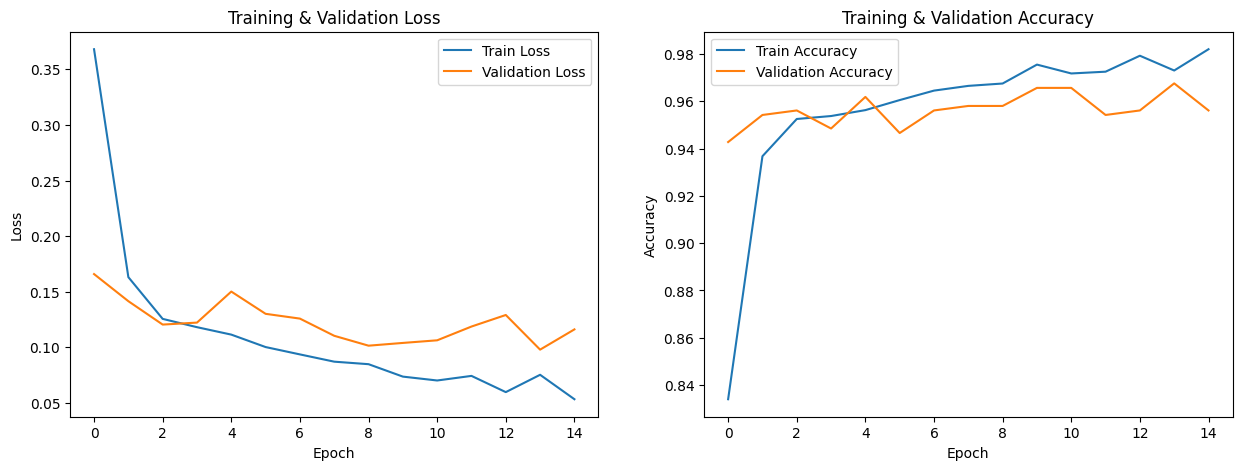

In [ ]:
# TODO: create subplots (use plt.subplots)
(fig, ax1, ax2) = ____.____(____)

# Plotting loss
ax1.plot(____, label='Train Loss')          # TODO: use training loss list
ax1.plot(____, label='Validation Loss')     # TODO: use validation loss list
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.____()   # TODO: call legend()

# Plotting accuracy
ax2.plot(____, label='Train Accuracy')      # TODO: use training accuracy list
ax2.plot(____, label='Validation Accuracy') # TODO: use validation accuracy list
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.____()   # TODO: call legend()

# TODO: display plot (use plt.show)
____.____()

### **Final Evaluation and Confusion Matrix**
Let's look at the final metrics on the validation set and visualize the **confusion matrix**. A confusion matrix shows exactly what types of errors the model is making.



Final Validation Metrics:
Accuracy: 0.9561
Precision: 0.9575 (Of all predicted 'pneumonia', how many were correct?)
Recall (Sensitivity): 0.9846 (Of all actual 'pneumonia' cases, how many did we find?)
F1-Score: 0.9708


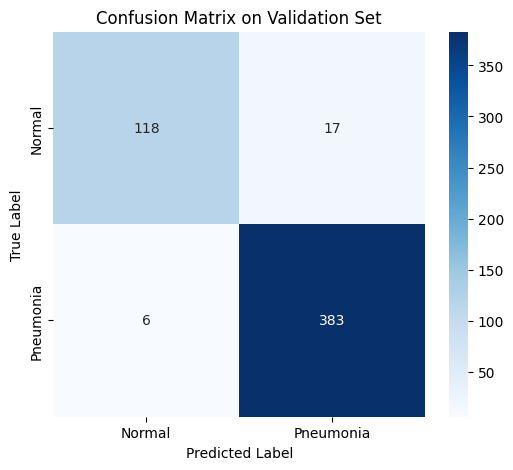


Final Test Metrics:
Accuracy: 0.8269
Precision: 0.7843 (Of all predicted 'pneumonia', how many were correct?)
Recall (Sensitivity): 0.9974 (Of all actual 'pneumonia' cases, how many did we find?)
F1-Score: 0.8781


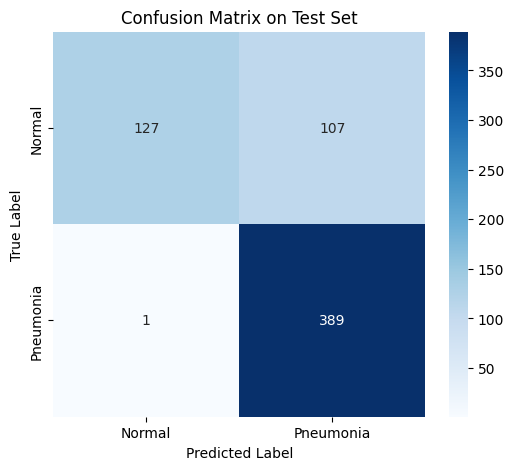

In [ ]:
# TODO: evaluate model on validation data
_, final_acc, final_prec, final_rec, final_f1, true_labels, pred_labels = evaluate(____, ____, ____, ____)

print(f"\nFinal Validation Metrics:")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_prec:.4f} (Of all predicted 'pneumonia', how many were correct?)")
print(f"Recall (Sensitivity): {final_rec:.4f} (Of all actual 'pneumonia' cases, how many did we find?)")
print(f"F1-Score: {final_f1:.4f}")

# TODO: compute confusion matrix (use true_labels and pred_labels)
cm = confusion_matrix(____, ____)
plt.figure(figsize=(6, 5))

# TODO: plot heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# TODO: evaluate model on test data
_, final_acc, final_prec, final_rec, final_f1, true_labels, pred_labels = evaluate(____, ____, ____, ____)

print(f"\nFinal Test Metrics:")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_prec:.4f} (Of all predicted 'pneumonia', how many were correct?)")
print(f"Recall (Sensitivity): {final_rec:.4f} (Of all actual 'pneumonia' cases, how many did we find?)")
print(f"F1-Score: {final_f1:.4f}")

# TODO: compute confusion matrix (use true_labels and pred_labels)
cm = confusion_matrix(____, ____)
plt.figure(figsize=(6, 5))

# TODO: plot heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Reflection**: In a medical context, is it worse to have a False Positive (predicting pneumonia when it's not there) or a False Negative (missing a case of pneumonia)? The answer determines whether you care more about precision or recall.

***

## **8. Summary and Next Steps**


In the upcoming notebooks, we will build on this foundation to explore more powerful techniques:
*   **Data Augmentation** to improve model generalization.
*   Using **Advanced CNN Architectures** like ResNet.
*   **Transfer Learning** to leverage models pre-trained on huge datasets.
